In [2]:
#pip install cookiecutter
#!pip install yellowbrick
#!pip install umap-learn

  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82701 sha256=fe1e0b41172dfc68b1b2ee72c0e95932582bdcb1dbf75e6c69ff970ec90e576a
  Stored in directory: c:\users\henrique\appdata\local\pip\cache\wheels\f2\64\75\df601da9514261c8cb0830b9515d2b94b5a51f09ddeae92b9e
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52593 sha256=7606e3ab9eea75afbbec668e6fea0fe2b1cfab94704eccc9da94bd4b147199ca
  Stored in directory: c:\users\henrique\appdata\local\pip\cache\wheels\e4\0e\b5\07c0c231aacb04e5d1046fe7459bb27ea79f95b5edbe88e435
Successfully built umap-learn pynndescent


# Solution Planning

In [34]:
# Input

1. Business Problem

    Selecting the most valuable customers to join a fidelization program

2. Data

    E-commerce sales during a year

In [35]:
# Output

1. List of customer will be part of insider program

    client_id  |  is_insider
     10323     |  yes

In [36]:
# Task

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegivel? O que são clientes de maior 'valor'?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV
        - Baixa recência
        - Alto basket size
        - Baixa probabilidade de churn
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução
        
    - Experiencia de compra:
        - Média alta das avaliações
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características dos clientes:
        - Idade
        - Localização
        
    - Escrever características do consumo
        - Atributos de clusterizaçao

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
        
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa nao é ser similar ou parecido com uma pessoa grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferencia de compra
    - Visita a empresa

Benchmark de soluções

# Imports

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

import statistics            as st
from sklearn import cluster as c
from sklearn import metrics as m

from matplotlib import pyplot as plt
from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

# Data Import

In [4]:
#load data
df = pd.read_csv('Ecommerce.csv',encoding="ISO-8859-1")

#drop
df = df.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data Description

In [5]:
df1 = df.copy()

## 1.1. Rename Columns 

In [6]:
cols_new = df1.columns

cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of columns: ', df1.shape[1])
print('Number of rows: ', df1.shape[0])

Number of columns:  8
Number of rows:  541909


## 1.3. Data Type

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. NA Check

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('% dataset removed: {:.2f}'.format(1 - (df1.shape[0]/df.shape[0])))

% dataset removed: 0.25


## 1.6. Change Types

In [11]:
#df1['invoice_no'] = df1['invoice_no'].replace(to_replace='\D', value='', regex=True)
#df1['stock_code'] = df1['stock_code'].replace(to_replace='\D', value='0', regex=True)

In [12]:
#df1.loc[df1['stock_code'] == '85123A']
#df1 = df1.replace(['C536383','C536379','C536391','C536506'],['536383','536379','536391','536506'])

In [13]:
#invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format= '%d-%b-%y')

#customer id
df1['customer_id'] = df1['customer_id'].astype(int)

#invoice no
#df1['invoice_no'] = df1['invoice_no'].astype(int)

#stock code
#df1['stock_code'] = df1['stock_code'].astype(int)

## 1.7. Descriptive Statistics

In [39]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(include = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numeric Attributes

In [43]:
#central tendency - mean, median, mode
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
ct3 = pd.DataFrame(num_attributes.apply(st.mode)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,ct3,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','mode','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,1.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,1.25,69.315077,452.219019,246924.542988


### 1.7.2. Categorical Attributes

In [ ]:
#invoice
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),'invoice_no'].drop_duplicates())

#stock code
#len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+',x))),'stock_code'])
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

#df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),:].head()

# 2.0 Variable Filtering

In [16]:
df2 = df1.copy()

In [ ]:
#numerical attributes 
#unit price
df2 = df2.loc[df2['unit_price'] > 0.01, :]

#stock code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

#quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

# 3.0 Feature Engineering

In [14]:
df3 = df2.copy()

## 3.1. Feature Creation

In [ ]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity',
              'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [ ]:
#gross revenue
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unity_price']

#monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

In [ ]:
#recency
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

In [ ]:
#frequency
df_frequency = df2_purchase[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

In [ ]:
#avg ticket
df_avg_ticket = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(
    columns={'gross_revenue':'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'], 2) 
df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

In [ ]:
#number of returns
df_returns = df2_returns[['customer_id', 'invoice_date']].drop_duplicates().groupby(
    'customer_id').count().reset_index().rename(columns={'invoice_no':'retunrs'})
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['returns'].isna(),'returns'] = 0
df_ref.isna().sum()

In [15]:
#df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity',
#              'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

##gross revenue
#df3['gross_revenue'] = df3['quantity']*df3['unit_price']

##monetary
#df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
#df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

##recency
#df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
#df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
#df_recency = df_recency[['customer_id', 'recency_days']].copy()
#df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

##frequency
#df_freq = df3[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
#df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

##average ticket
#df_avg_ticket = df3[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={
#    'gross_revenue':'avg_ticket'})
#df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')
#df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# 4.0 EDA

In [17]:
df4 = df3.copy()

# 5.0 Data Preparation

In [18]:
df5 = df4.copy()

In [ ]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_date'] = ss.fit_transform(df5[['invoice_date']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['returns'] = ss.fit_transform(df5[['returns']])

# 6.0 Feature Selection

In [19]:
df6 = df5.copy()

In [20]:
print('Number of rows: ', df2.shape[0])

Number of rows:  406829


# 7.0 Hyperparameter Fine-Tuning

In [26]:
X = df6.drop(columns = 'customer_id')

clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

## 7.1 Within-Cluster Sum of Square (WSS)

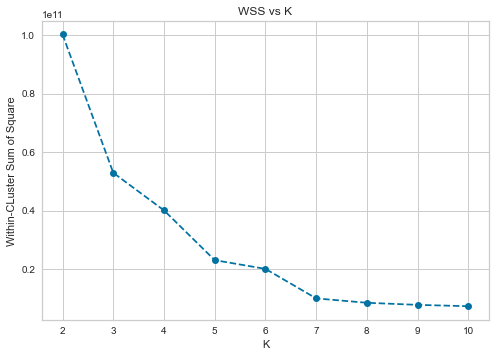

In [27]:
wss = []
for k in clusters:
    #model
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)

#plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-CLuster Sum of Square');
plt.title('WSS vs K');

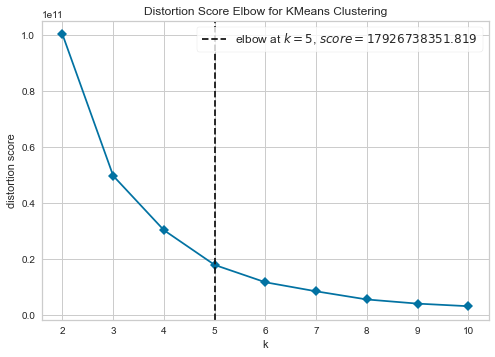

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings = False)
kmeans.fit(X)
kmeans.show()

## 7.2. Silhouette Score (SS)

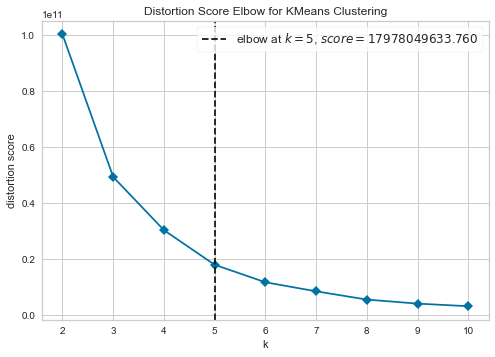

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metrics='silhouette', timings = False)
kmeans.fit(X)
kmeans.show()

## 7.2. Silhouette Analysis

IndexError: index 3 is out of bounds for axis 0 with size 3

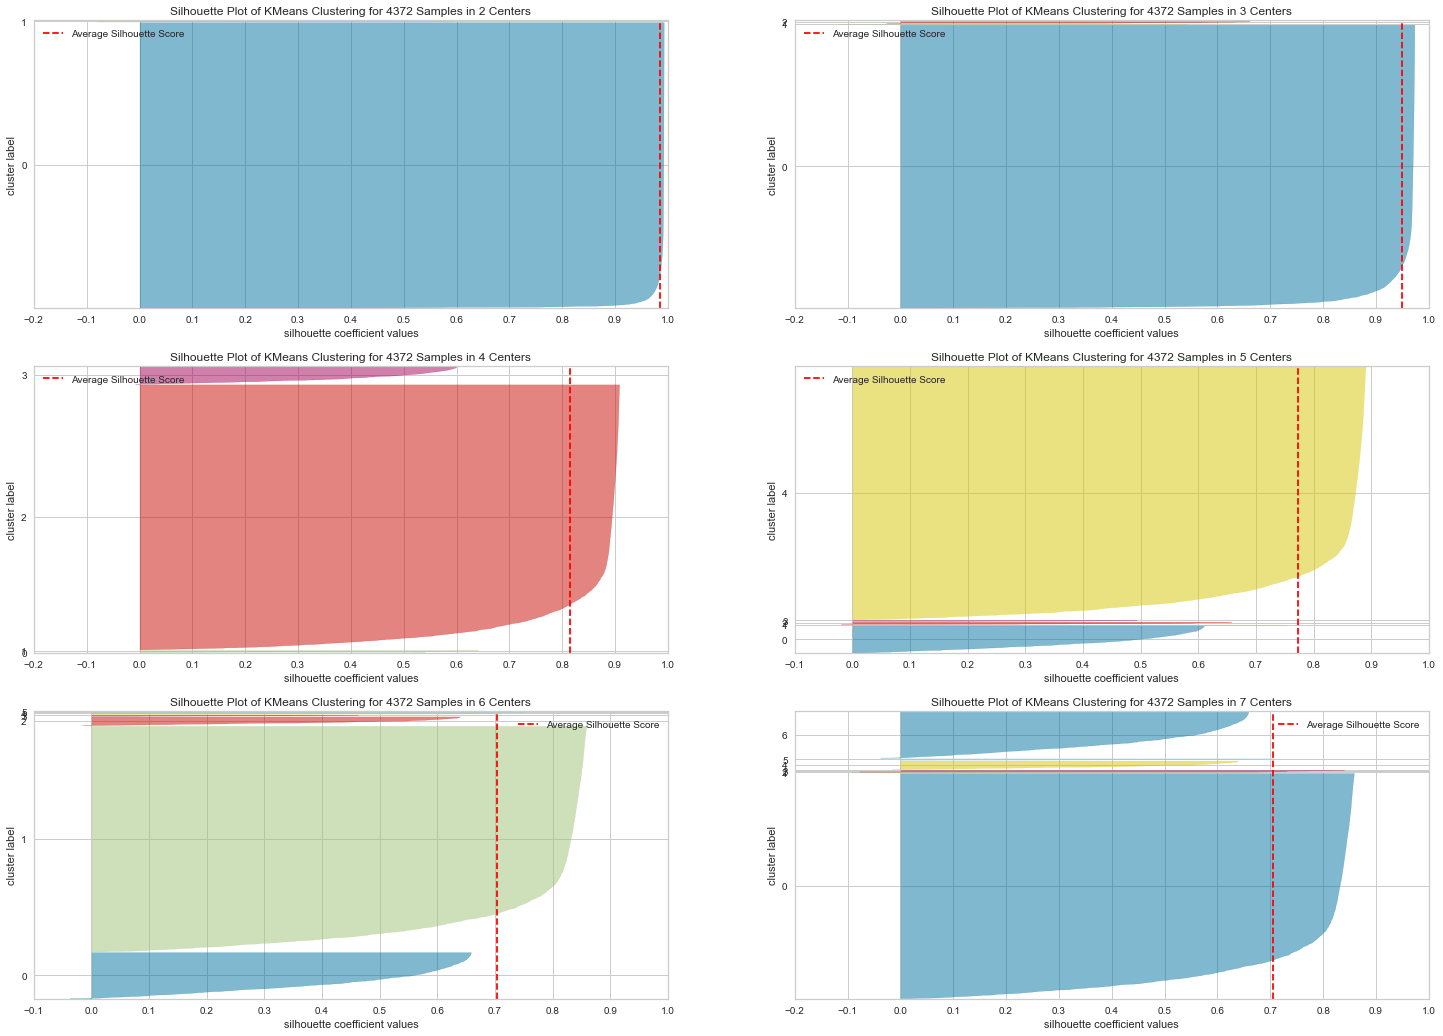

In [30]:
fig, ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1. K-Means

In [31]:
k = 4

#model
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
   
#model training
kmeans.fit(X)
    
#clustering
labels = kmeans.labels_

In [32]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))

#SS
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 40056254626.30001
SS value: 0.8139972028952444


# 9.0 Cluster Analysis

In [33]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1. Cluster Visualization

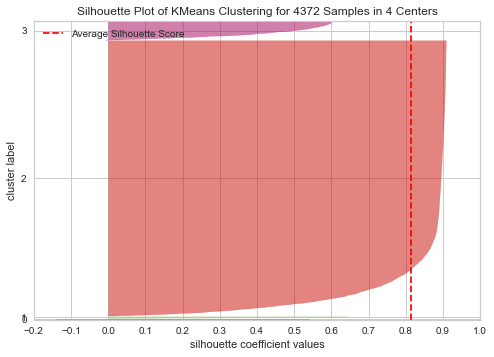

In [34]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2d

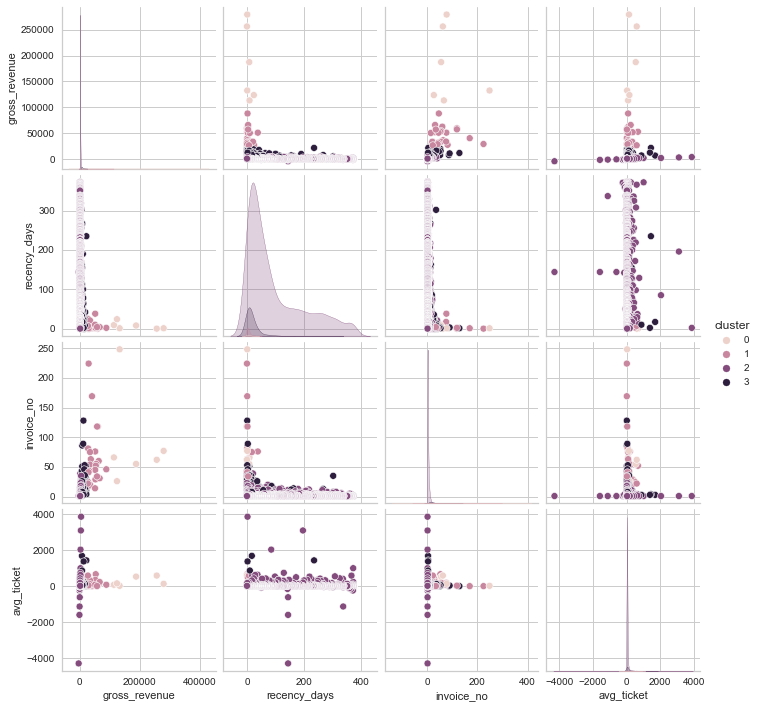

In [35]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

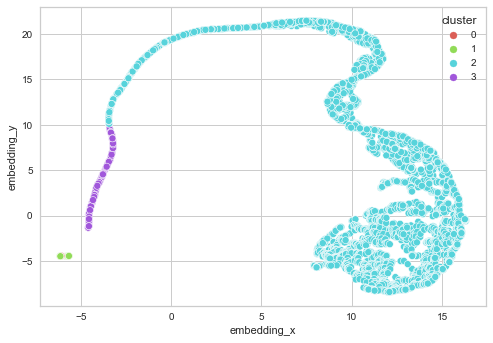

In [36]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
               hue='cluster',
               palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
               data=df_viz)

## 9.4 Cluster Profile

In [38]:
#number of customer
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

#average gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#average recency days
df_avg_recency_day = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_day, how='inner', on='cluster')

#average invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

#average ticket
df_avg_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,6,0.137237,182181.981667,7.166667,89.000000,253.626345
1,1,28,0.640439,42614.387143,6.178571,57.821429,162.862605
2,2,4071,93.115279,946.696250,96.969295,3.641120,25.359654
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


# 3.0 Variable Filtering